Use GANs to create art - Monet CycleGan Project - **Test Notebook**
- Written by:
  - Matan Ofri
  - Itamar Kirsch
  - Chen Shiri
  - Liel Pargamentnik
- You can view images from the **Normal Data Set** after they have been turned into Monet paintings at the following link:<br> https://drive.google.com/drive/folders/1_oZtryAlvEeK6bO-DlB-EOhpeldbnPLs?usp=sharing
- You can download the **Weights File** at the following link:<br> https://drive.google.com/file/d/1FGiN_v4PtvuJdtNrWiumD60Qp-7ofXc0/view?usp=sharing

Tensorflow Addons
- This addon must be installed for the "InstanceNormalization" library function.

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa # Install tensorflow-addons
import keras as ker
import numpy as np
import os
import cv2
import zipfile
from keras import initializers, layers, Input, backend, Model, losses, optimizers
from keras.layers import Conv2D, Conv2DTranspose, ReLU, Add, Activation ,Concatenate, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.initializers import RandomNormal
from keras.metrics import BinaryAccuracy
from keras.utils import register_keras_serializable
from matplotlib import pyplot as plt
from numpy import load ,ones ,zeros ,asarray
from numpy.random import randint
from google.colab.patches import cv2_imshow
from random import random
import random as rand
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


# Generator and Discriminator models
❗ This Section must be loaded as "black-box", of course you can take a look 👀


In [3]:
img_height = 320
img_width = 320
img_channels = 3
batch_size = 4
epochs = 100
learning_rate=0.0002
beta_val=0.5
img_shape = (img_width, img_height, img_channels)
num_of_resnet_blocks = 12

In [4]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    # Override in Layer
    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [5]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Encoder Block
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='encoder'):
    enc_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}')(input_layer)

    if apply_instancenorm:
        enc_layer = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(enc_layer)
    enc_layer = activation(enc_layer)
    return enc_layer

# Resnet Block
def resnet_block(input_layer, size=3, strides=1, name='resnet'):
    filters = input_layer.shape[-1]
    res_layer = ReflectionPadding2D()(input_layer)
    res_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='valid',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}_1')(res_layer)
    res_layer = ker.layers.ReLU()(res_layer)
    res_layer = ReflectionPadding2D()(res_layer)
    res_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='valid',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}_2')(res_layer)
    res_layer = ker.layers.Add()([res_layer, input_layer])
    return res_layer

# Decoder Block
def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='decoder'):
    dec_layer = ker.layers.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'block-{name}')(input_layer)

    if apply_instancenorm:
        dec_layer = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(dec_layer)
    dec_layer = ker.layers.ReLU()(dec_layer)
    return dec_layer

In [6]:
def generator(height=img_height, width=img_width, channels=img_channels, resnet_blocks=num_of_resnet_blocks):
    # Input:
    inputs = ker.layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder:
    # 1 - (batch_size, 256, 256, 64)
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=ker.layers.ReLU(), name='enc_1')
    # 2 - (batch_size, 128, 128, 128)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='enc_2')
    # 3 - (batch_size, 64, 64, 256)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='enc_3')

    # Resnet:
    # The value of "resnet_blocks" times, every Layer is (batch_size, 64, 64, 256)
    res = enc_3
    for i in range(resnet_blocks):
        res = resnet_block(res, 3, 1, name=f'resnet_block_{i+1}')

    # Decoder:
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_1')([res, enc_3])
    # 1 - (batch_size, 128, 128, 128)
    dec_1 = decoder_block(skip_con, 128, 3, 2, apply_instancenorm=True, name='block_1')
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2])
    # 2 - (batch_size, 256, 256, 64)
    dec_2 = decoder_block(skip_con, 64,  3, 2, apply_instancenorm=True, name='block_2')
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1])

    # Output:
    # 1 - (batch_size, 256, 256, 3)
    outputs = last = ker.layers.Conv2D(channels, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(skip_con)

    generator = Model(inputs, outputs)
    return generator

In [7]:
def discriminator(height=img_height, width=img_width, channels=img_channels):
    # Input:
    inputs = ker.layers.Input(shape=[height, width, channels], name='input_image')
    inputs_patch = ker.layers.experimental.preprocessing.RandomCrop(height=75, width=75, name='input_image_patch')(inputs)

    # Encoder:
    # 1 - (batch_size, 128, 128, 64)
    x = encoder_block(inputs_patch, 64,  4, 2, apply_instancenorm=False, activation=ker.layers.LeakyReLU(0.2), name='block_1')
    # 2 - (batch_size, 64, 64, 128)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_2')
    # 3 - (batch_size, 32, 32, 256)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_3')
    # 4 - (batch_size, 32, 32, 512)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_4')

    # Output:
    # 1 - (batch_size, 29, 29, 1)
    outputs = ker.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)

    discriminator = Model(inputs, outputs)
    return discriminator

In [8]:
# monet_generator transforms normal photos to Monet-esque paintings:
monet_generator = generator(height=None, width=None, resnet_blocks=num_of_resnet_blocks)
# normal_generatort ransforms Monet paintings to be more like normal photos:
normal_generator = generator(height=None, width=None, resnet_blocks=num_of_resnet_blocks)
# monet_discriminator differentiates real Monet paintings and generated Monet paintings:
monet_discriminator = discriminator(height=None, width=None)
# normal_discriminator differentiates real photos and generated photos:
normal_discriminator = discriminator(height=None, width=None)

class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        normal_generator,
        monet_discriminator,
        normal_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_generator
        self.normal_gen = normal_generator
        self.monet_disc = monet_discriminator
        self.normal_disc = normal_discriminator
        self.lambda_cycle = lambda_cycle

    # Override in Model
    def compile(
        self,
        monet_gen_optimizer,
        normal_gen_optimizer,
        monet_disc_optimizer,
        normal_disc_optimizer,
        gen_loss,
        disc_loss,
        cycle_loss, # monet -> normal -> monet || normal -> monet -> normal
        identity_loss
    ):
        super(CycleGan, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.normal_gen_optimizer = normal_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.normal_disc_optimizer = normal_disc_optimizer
        self.gen_loss = calc_generator_loss
        self.disc_loss = calc_discriminator_loss
        self.cycle_loss = calc_cycle_loss
        self.identity_loss = calc_identity_loss

    # Override in Model
    def call(self, inputs, training=False):
      # Assume inputs is a tuple containing images from both domains: (monet_images, normal_images)
      monet_images, normal_images = inputs

      # Translate normal images to Monet style and back to normal
      fake_monet = self.monet_gen(normal_images, training=False)
      cycled_normal = self.normal_gen(fake_monet, training=False)

      # Translate Monet images to normal style and back to Monet
      fake_normal = self.normal_gen(monet_images, training=False)
      cycled_monet = self.monet_gen(fake_normal, training=False)

      # Identity mapping (optional, but often included in CycleGANs)
      same_monet = self.monet_gen(monet_images, training=False)
      same_normal = self.normal_gen(normal_images, training=False)

      # Discriminator outputs (not typically used in the call method, but included for completeness)
      disc_real_monet = self.monet_disc(monet_images, training=False)
      disc_real_normal = self.normal_disc(normal_images, training=False)
      disc_fake_monet = self.monet_disc(fake_monet, training=False)
      disc_fake_normal = self.normal_disc(fake_normal, training=False)

      return fake_monet, cycled_normal, fake_normal, cycled_monet, same_monet, same_normal, disc_real_monet, disc_real_normal, disc_fake_monet, disc_fake_normal

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [9]:
def calc_discriminator_loss(real, generated):
  real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
  generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
  return (real_loss + generated_loss) * 0.5

def calc_generator_loss(generated):
  return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, Lambda):
  loss = tf.reduce_mean(tf.square(real_image - cycled_image))
  return Lambda * loss

def calc_identity_loss(real_image, complex_image, Lambda):
  loss = tf.reduce_mean(tf.abs(real_image - complex_image))
  return Lambda * loss * 0.5

In [10]:
monet_generator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)
normal_generator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)

monet_discriminator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)
normal_discriminator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)

loaded_gan_model = CycleGan(monet_generator, normal_generator, monet_discriminator, normal_discriminator)
loaded_gan_model.compile(monet_gen_optimizer=monet_generator_optimizer,
                  normal_gen_optimizer=normal_generator_optimizer,
                  monet_disc_optimizer=monet_discriminator_optimizer,
                  normal_disc_optimizer=normal_discriminator_optimizer,
                  gen_loss=calc_generator_loss,
                  disc_loss=calc_identity_loss,
                  cycle_loss=calc_cycle_loss,
                  identity_loss=calc_discriminator_loss
                  )
loaded_gan_model.built = True

# Test Monet CycleGAN Model

1. Load Weights

In [11]:
loaded_gan_model.load_weights("/content/drive/Shareddrives/Monet DL Project/Weights/FinalWights.h5")

2. **[DEMO] Test** the CycleGAN model on a random normal photo from library

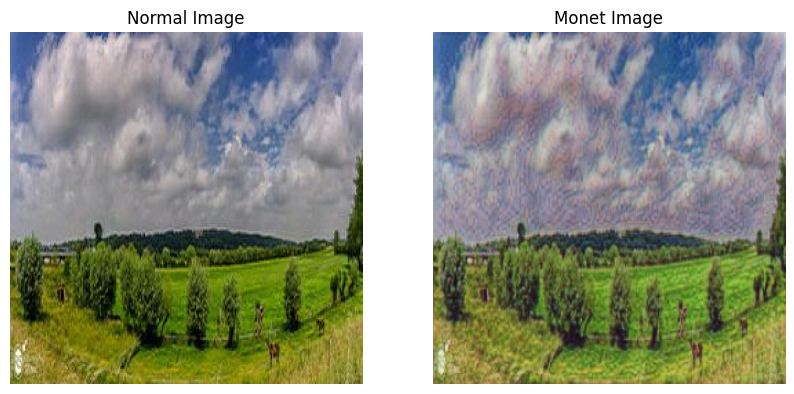

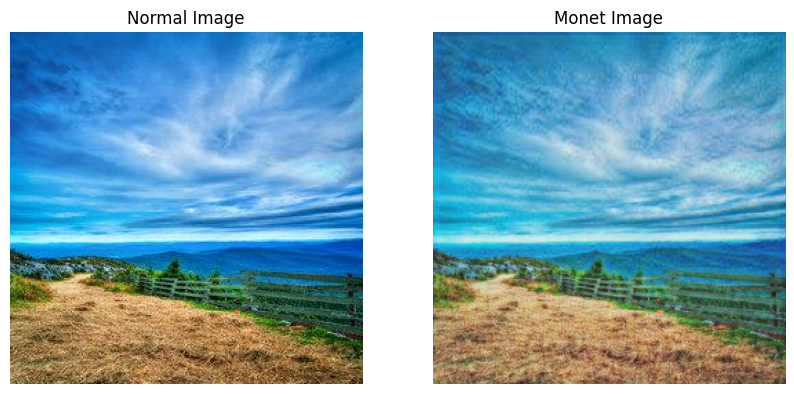

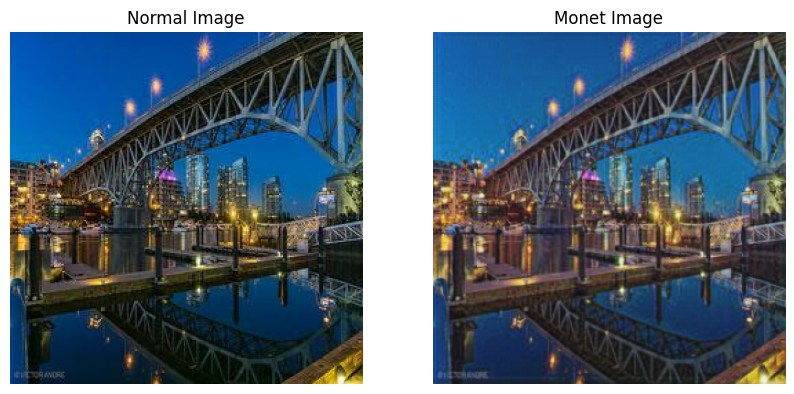

In [ ]:
directory = "Add the path to the files here"
all_photos = os.listdir(directory)
selected_photos = rand.sample(all_photos, 3)

for filename in selected_photos:
    srcimg = cv2.imread(os.path.join(directory, filename))

    img = cv2.resize(srcimg, (img_height, img_width))
    img = img.astype('float32')
    img = (img - 127.5) / 127.5
    img = np.expand_dims(img, axis=0)
    outimg = loaded_gan_model.monet_gen(img, training=False)
    outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Normal Image')
    plt.imshow(cv2.cvtColor(srcimg, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Monet Image')
    plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

3. **[DEMO] Test** the CycleGAN model on your photo

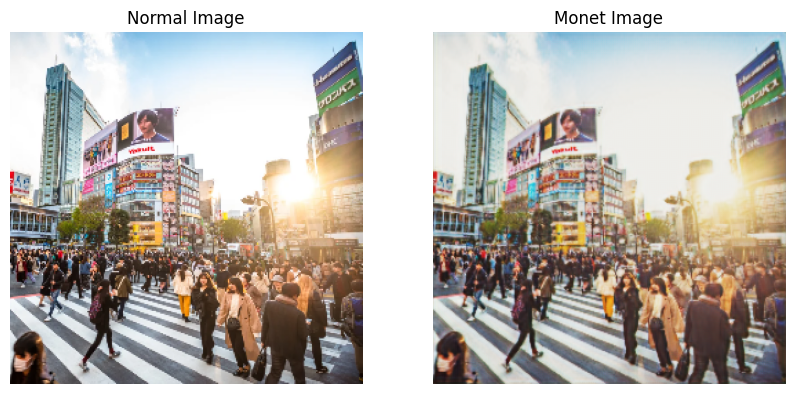

In [13]:
photoPath = "/content/drive/Shareddrives/Monet DL Project/Image20240322102737.jpg"
srcimg = cv2.imread(photoPath)
img = cv2.resize(srcimg, (img_height, img_width))
img = img.astype('float32')
img = (img - 127.5) / 127.5
img = np.expand_dims(img, axis=0)
outimg = loaded_gan_model.monet_gen(img, training=False)
outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Normal Image')
plt.imshow(cv2.cvtColor(srcimg, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Monet Image')
plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

4. Creating a ZIP file containing all the images from the **Normal Data Set** after they have been turned into Monet paintings
- According to the task instructions, the final images created in this section are images of size 320x320x3

In [ ]:
directory = "/content/drive/Shareddrives/Monet DL Project/Data/Normal"
output_directory = "/content/drive/Shareddrives/Monet DL Project/Data"
zip_filename = os.path.join(output_directory, "images.zip")

with zipfile.ZipFile(zip_filename, 'w') as myzip:
    all_photos = os.listdir(directory)
    for filename in all_photos:
        try:
            srcimg = cv2.imread(os.path.join(directory, filename))
            if srcimg is None:
                continue

            img = cv2.resize(srcimg, (320, 320))
            img = img.astype('float32')
            img = (img - 127.5) / 127.5
            img = np.expand_dims(img, axis=0)
            outimg = loaded_gan_model.monet_gen(img, training=False)
            outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
            output_filename = f"processed_{filename}"

            temp_path = os.path.join(output_directory, output_filename)
            plt.figure(figsize=(3.2, 3.2), dpi=100)
            plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            if os.path.exists(temp_path):
                myzip.write(temp_path, arcname=output_filename)
                os.remove(temp_path)
            else:
                print(f"Failed to save image: {temp_path}")
        except Exception as e:
            print(f"An error occurred processing {filename}: {e}")

with zipfile.ZipFile(zip_filename, 'r') as check_zip:
    print("Contents of the zip file:", check_zip.namelist())

5. Create a Monet painting from a JPG image of your choice
- According to the task instructions, the final image created in this section is image of size 320x320x3

In [ ]:
directory = "Add the path to the files here"
output_directory = "Add the path to the files here"

all_photos = os.listdir(directory)
for filename in all_photos:
    srcimg = cv2.imread(os.path.join(directory, filename))
    img = cv2.resize(srcimg, (320, 320))
    img = img.astype('float32')
    img = (img - 127.5) / 127.5
    img = np.expand_dims(img, axis=0)
    outimg = loaded_gan_model.monet_gen(img, training=False)
    outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
    output_filename = f"processed_{filename}"

    temp_path = os.path.join(output_directory, output_filename)
    plt.figure(figsize=(3.2, 3.2), dpi=100)
    plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
    plt.close()